In [10]:
import cv2
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import random
from torchvision.ops import box_iou

from safetensors import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import torch
from torchvision.transforms import transforms

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device available")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA device available")
else:
    device = torch.device("cpu")
    print("CPU device available")

CUDA device available


In [12]:
train_dir = './data/object_detection/train/'
val_dir = './data/object_detection/val/'
test_dir = '../train/Task1/'

In [13]:
test_img_paths = os.listdir(test_dir)
test_paths = []
for path in test_img_paths:
    if path.endswith('.jpg'):
        test_paths.append(path)

In [14]:
def compute_iou(boxA, boxB):
    # boxA and boxB are tuples/lists representing bounding boxes in the format (x1, y1, x2, y2)
    # where (x1, y1) are the coordinates of the top-left corner
    # and (x2, y2) are the coordinates of the bottom-right corner

    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Calculate the area of intersection rectangle
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Calculate the area of the individual bounding boxes
    boxA_area = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxB_area = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate the area of union
    union_area = boxA_area + boxB_area - intersection_area

    # Calculate IOU
    iou = intersection_area / union_area

    return iou

In [15]:
def generate_bounding_box(img_h, img_w):
    try:
        x1_range = (0, img_w - 1)
        x1 = random.randint(*x1_range)
        
        x2_range = (x1 + 100, img_w)
        x2 = random.randint(*x2_range)
        
        y1_range = (0, img_h - 1)
        y1 = random.randint(*y1_range)
        
        y2_range = (y1 + 60, img_h)
        y2 = random.randint(*y2_range)

        return x1, y1, x2, y2
    except ValueError:
        return generate_bounding_box(img_h, img_w)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(self.root + 'images/')))
        self.labels = list(sorted(os.listdir(self.root + 'labels/')))
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = read_image(self.root + 'images/' + self.images[idx]).float() / 255.0
        color_chanels, image_height, image_width = img.shape
        
        # scale_width = 224.0 / 1920  # scale bounding box for img resize
        # scale_height = 224.0 / 1080  # scale bounding box for img resize
        
        label_path = self.root + 'labels/'+ self.labels[idx]
        boxes = []
        labels = []
        
        # Positive examples
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                label = data[0]
                class_id, x_center, y_center, width, height = map(float, data)
                
                # Convert relative coordinates to absolute coordinates
                x_center *= image_width
                y_center *= image_height
                width *= image_width
                height *= image_height
                
                # Calculate top-left and bottom-right coordinates
                x1 = int(x_center - width / 2)
                y1 = int(y_center - height / 2)
                x2 = int(x_center + width / 2)
                y2 = int(y_center + height / 2)
                
                if (x2 > x1 and 
                        y2 > y1 and 
                        0 <= x1 < image_width and 
                        0 <= y1 < image_height and 
                        0 <= x2 < image_width and 
                        0 <= y2 < image_height):
                    boxes.append([x1, y1, x2, y2])
                    labels.append(int(1))
        
        # Negative examples ( get 20 positive example from each image )
        initial_size = len(boxes) * 2
        while len(boxes) < initial_size:
            x1, y1, x2, y2 = generate_bounding_box(image_height, image_width)
            proposed_box = [x1, y1, x2, y2]

            skip_loop = False
            for box in boxes:
                if compute_iou(box, proposed_box) >= 0.4:
                    skip_loop = True
                    break
            if skip_loop:
                continue
            
            boxes.append(proposed_box)
            labels.append(int(0))
        
        boxes = torch.tensor(boxes, dtype=torch.float32, device=device)
        labels = torch.tensor(labels, dtype=torch.int64, device=device)
        img = img.to(device)
        target = {"boxes": boxes, "labels": labels}
        
        # if self.transform:
        #     img = self.transform(img)
        
        return img, target

In [17]:
img_transform = transforms.Compose([
    transforms.Resize((1920, 1080)),
])

In [18]:
train_dataset = CustomDataset(train_dir, img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

val_dataset = CustomDataset(val_dir, img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# Load a pre-trained model
model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Define the number of classes (including the background)
num_classes = 2  # 1 class (object) + background

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [10]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [11]:
from tqdm import tqdm
import torch
import torch.optim as optim

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move model to the right device
model.to(device)

# Parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=5e-4, momentum=0.9, weight_decay=5e-5)
num_epochs = 10

# Training loop
for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0
    model.train()
    for images, targets in tqdm(train_dataloader):
        loss_dict = model(images, targets)
        batch_losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        batch_losses.backward()
        optimizer.step()
        
        epoch_loss += batch_losses.item()

    # Calculate average loss
    average_loss = epoch_loss / (len(train_dataloader) )
    print(f"Epoch: {epoch}, Loss: {average_loss:.4f}")

100%|██████████| 100/100 [00:50<00:00,  1.99it/s]


Epoch: 1, Loss: 1.1812


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Epoch: 2, Loss: 0.7675


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Epoch: 3, Loss: 0.7304


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Epoch: 4, Loss: 0.6851


100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


Epoch: 5, Loss: 0.6659


100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


Epoch: 6, Loss: 0.6378


100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


Epoch: 7, Loss: 0.6040


100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


Epoch: 8, Loss: 0.5919


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Epoch: 9, Loss: 0.5773


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]

Epoch: 10, Loss: 0.5562


In [29]:
torch.save(model.state_dict(), 'car_detection_model.pth')

In [8]:
model.load_state_dict(torch.load('car_detection_model.pth', map_location=device))

<All keys matched successfully>

In [23]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

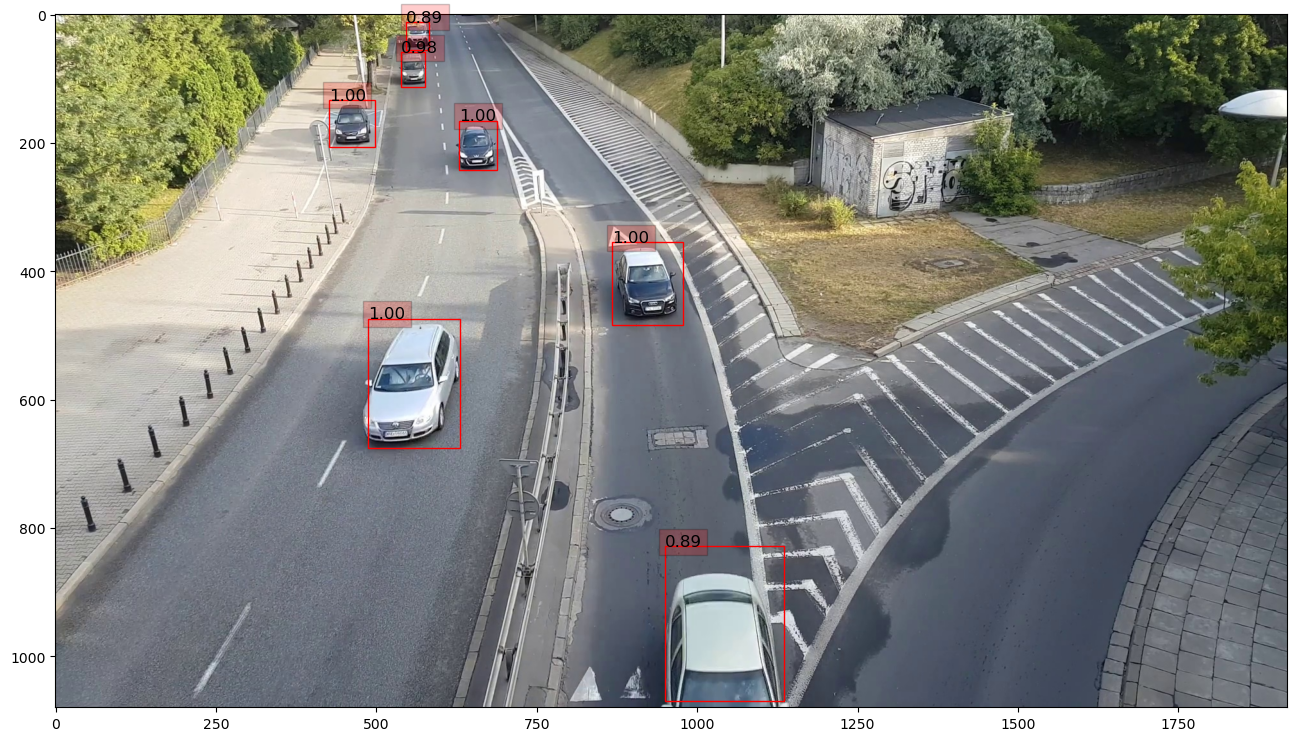

KeyboardInterrupt: 

In [24]:
import time
from matplotlib import patches
from IPython.core.display_functions import clear_output

detection_threshold = 0.6
model.eval()
for idx, (images, targets) in enumerate(val_dataloader):
    outputs = model(images)

    for i, image in enumerate(images):
        np_image = image.permute(1, 2, 0).cpu().numpy()
        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()


        plt.figure(figsize=(16, 9), dpi=100)
        plt.imshow(np_image)
        for box, score, label in zip(boxes, scores, labels):
            if score >= detection_threshold and label == 1:
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
                plt.gca().add_patch(rect)
                plt.text(x1, y1, f'{score:.2f}', color='black', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
        
        plt.show()
        time.sleep(0.2)
        clear_output()  

In [40]:
import time
from matplotlib import patches
from IPython.core.display_functions import clear_output

for path in test_paths:

    img = read_image(test_dir + path) / 255.0
    img = img_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    outputs = model(img)
    
    img = img.squeeze(0)
    np_image = img.permute(1, 2, 0).cpu().numpy()
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    labels = outputs[0]['labels'].data.cpu().numpy()


    plt.figure(figsize=(16, 9), dpi=100)
    plt.imshow(np_image)
    for box, score, label in zip(boxes, scores, labels):
        if score >= detection_threshold and label == 1:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1 + 1, y2 - y1 + 1, linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1, f'{score:.2f}', color='black', fontsize=12, bbox=dict(facecolor='red', alpha=0.2))
    
    plt.show()
    time.sleep(2)
    clear_output()